In [10]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from src.utils.visualize import plot_voronoi
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point
from PIL import Image
import numpy as np
import os
from tqdm import tqdm

In [11]:
#train_set = r"../data/Ki67/SHIDC-B-Ki-67/Train/p1_0308_3"
#train_set = r"../test_images/dots"
test_set = r"../data/Ki67/SHIDC-B-Ki-67/Test/"
JSON_EXT = ".json"
JPG_EXT = ".jpg"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 120

In [12]:
def filter_polygons(polygon,img_shape):
    x = img_shape[0]
    y = img_shape[1]
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
    if minx <= -1 or maxx > x:
        return False
    if miny <= -1 or maxy > y:
        return False
    return True

def get_label_idx(polygon,points_df):
    x = points_df.x
    y = points_df.y
    labels = points_df.label_id
    for idx , xs in enumerate(x):
        p = Point(x[idx],y[idx])
        if polygon.contains(p):
            return idx

def get_regions(image_name,plot=False):
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)
    if json_df.empty:
        return (False, False)

    cell_points = list(zip(json_df.x,json_df.y))
    labels = json_df.label_id
    vor = Voronoi(cell_points)
    polygons = []
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    #print(vor.points)
    tmp_df = json_df.copy()
    labels_list = []
    if plot:
        plot_voronoi(vor,img_arr,points_size=5,show_points=True,show_verticles=False,line_width=0.3)
    for idx ,region in enumerate(vor.regions):
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            x = Polygon(polygon)
            if x.is_empty:
                continue
            
            if filter_polygons(x,img_arr.shape):
                idx = get_label_idx(x,tmp_df)
                #print(idx)
                #print(len(labels))
                polygons.append(x)
                labels_list.append(labels[idx])
                if plot:
                    plt.fill(*zip(*polygon))
    
    return polygons,labels_list


In [13]:
def plot(image_name):
    json_path = image_name+JSON_EXT

    json_df = pd.read_json(json_path)
    cell_points = list(zip(json_df.x,json_df.y))
    vor = Voronoi(cell_points)
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    plot_voronoi(vor,img_arr,show_points=True,show_verticles=False,line_width=0.3)
    #plt.gca().invert_xaxis()
    #plt.gca().invert_yaxis()

In [14]:

def plot_arr(img_arr):
    fig, ax = plt.subplots()
    ax.imshow(img_arr)
   # ax.set_ylim([0, 180])
   # ax.set_xlim([0, 180])
   # plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    return fig


In [15]:
def get_pixels(image_name,polygon,plot=False):
    img_path = image_name+JPG_EXT
    img_arr = plt.imread(img_path)
    
    #plot_arr(img_arr)
    #print(img_arr.shape)
    
    (miny, minx, maxy, maxx)=[int(item) for item in list(polygon.bounds)]
   # print(polygon.bounds)
    shape = img_arr.shape
    x_range = range(minx,maxx)
    y_range = range(miny,maxy)
    if plot:
        test = np.copy(img_arr)
    mask = np.copy(img_arr[minx:maxx,miny:maxy])
    for x in x_range:
        for y in y_range:
            p = Point(y,x)
            if not polygon.contains(p):
                if plot:
                    test[x,y]=test[x,y]*[255,0,0]
                mask[x-minx,y-miny]=mask[x-minx,y-miny]*[0,0,0]
    #
    if plot:
        plot_arr(test)
        plot_arr(mask)
    return mask

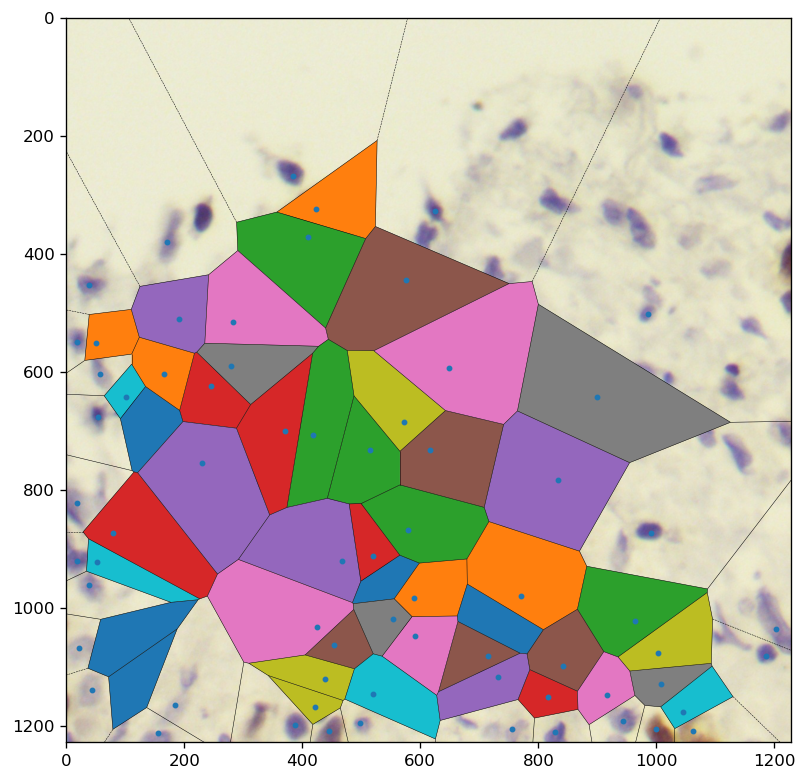

In [320]:
polygons,labels = get_regions(train_set,True)

In [ ]:
plot(train_set)

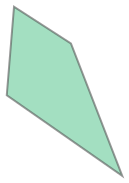

In [176]:
polygons[0]

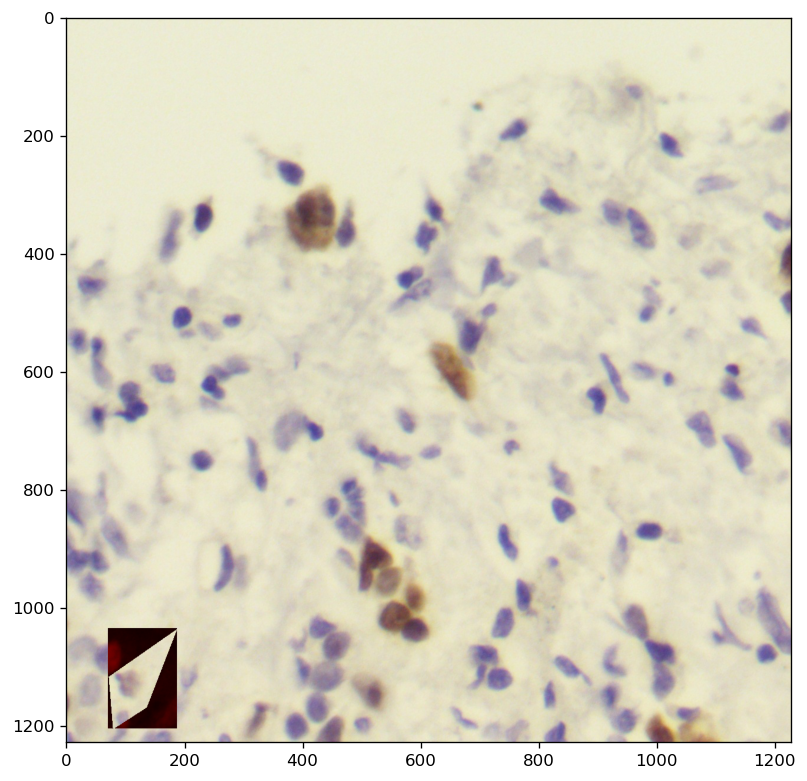

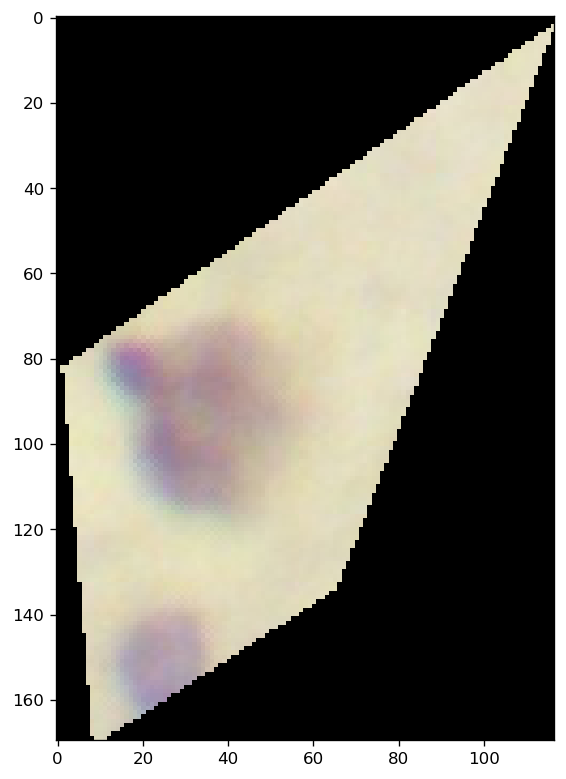

In [177]:
x = get_pixels(train_set,polygons[0],True)

In [113]:
len(polygons)

47

In [6]:
def create_set(path,prefix,distpath):
    print('Working at: ',path)
    filelist = []
    for root, dirs, files in os.walk(path, topdown=False):
        for file in files:
            filename = file.split('.')[0]
            ext = file.split('.')[1]
            if ext == 'jpg':
                filepath = os.path.join(root,filename)
                if os.path.exists(filepath+'.json') and os.path.getsize(filepath+'.json') > 1:
                    filelist.append((filename,filepath))
    df = pd.DataFrame(columns=['filename','label'])
    for filename, filepath in tqdm(filelist):
        try:
            polygons,labels = get_regions(filepath,False)
            if polygons is False:
                continue
            it = 0
            for idx, polygon in enumerate(polygons):
                arr = get_pixels(filepath,polygon,False)
                im = Image.fromarray(arr)
                f = filename+"_"+str(it)+".jpg"
                dist = os.path.join(distpath,f)
                it +=1
                l = labels[idx]
                df_tmp = pd.DataFrame({
                    'filename':[f],
                    'label':[l]
                })
                df=df.append(df_tmp)
                im.save(dist)
                #plt.show()
            #break

            df.to_csv(os.path.join(distpath,"labels.csv"))
        except Exception as e:
            print("Error with file: ", filename," : ", e)
            

In [18]:
train_path = r"../data/Ki67/SHIDC-B-Ki-67/Test/"
#train_path = r"../test_images/"

In [19]:
create_set(train_path,"test",r"../dl/test-voronoi")

  0%|                                                                                          | 0/700 [00:00<?, ?it/s]

Working at:  ../data/Ki67/SHIDC-B-Ki-67/Test/


  1%|▋                                                                               | 6/700 [03:40<6:30:24, 33.75s/it]

Error with file:  p10_0050_6  :  QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1362393473  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 20%|███████████████▍                                                            | 142/700 [1:20:06<5:02:35, 32.54s/it]

Error with file:  p14_0032_2  :  QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1439487182  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 32%|████████████████████████▍                                                   | 225/700 [1:58:45<5:47:30, 43.90s/it]

Error with file:  p16_0387_1  :  QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1478462615  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 44%|█████████████████████████████████▏                                          | 306/700 [2:42:10<2:26:01, 22.24s/it]

Error with file:  p19_0114_3  :  QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1522228043  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0

Error with file:  p19_0115_5  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1522228043  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 58%|█████████████████████████████████████████████▌                                | 409/700 [3:46:27<53:19, 11.00s/it]

Error with file:  p21_0259_5  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1587069449  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 63%|███████████████████████████████████████████████▊                            | 440/700 [3:58:42<1:40:29, 23.19s/it]

Error with file:  p22_0027_10  :  QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1599405787  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 94%|█████████████████████████████████████████████████████████████████████████▎    | 658/700 [5:47:10<19:48, 28.30s/it]

Error with file:  p8_0049_9  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1708802550  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0



 94%|█████████████████████████████████████████████████████████████████████████▋    | 661/700 [5:47:18<13:20, 20.53s/it]

Error with file:  p8_0050_3  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1708920199  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0

Error with file:  p8_0050_5  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1708920199  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qinterior-keep  _maxoutside  0

Error with file:  p8_0051_1  :  QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull v Qz Qbb Qc
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1708920199  voronoi  Qz-infinity-point  Qbbound-last  Qcoplanar-keep
  _pre-merge  _zero-centrum  Qin

100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [6:01:54<00:00, 31.02s/it]
